In [1]:
import polars as pl # similar pandas, faster than pandas 10x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
from pandas.api.types import CategoricalDtype
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from branca.colormap import LinearColormap

# 1. LOAD DATA
## Load CSV/Parquet files into Polars DataFrames
#### If Parquet exists, read it directly; otherwise read CSV, write Parquet, then read

In [2]:
# Paths
csv_dir = Path("../../data/csv")
parquet_dir = Path("../../data/parquet")
parquet_dir.mkdir(exist_ok=True)

tables = ["flights_sample_3m", 
         "airports_clean"]

dfs = {}

for table in tables:
    csv_path = csv_dir / f"{table}.csv"
    parquet_path = parquet_dir / f"{table}.parquet"

    try:
        if parquet_path.exists(): 
            print(f"{parquet_path} already exists, reading Parquet...")
        else:
            print(f"{parquet_path} not found, reading CSV and writing Parquet...")
            (pl.scan_csv(csv_path, low_memory=True).sink_parquet(parquet_path))
            print(f"{parquet_path} has been created.\n")

        # Read parquet
        df = pl.read_parquet(parquet_path)
        dfs[table] = df
        print(f"{table}: {df.shape[0]} rows, {df.shape[1]} columns\n")

    except Exception as e:
        print(f"Error reading {table}: {e}")

..\..\data\parquet\flights_sample_3m.parquet already exists, reading Parquet...
flights_sample_3m: 3000000 rows, 32 columns

..\..\data\parquet\airports_clean.parquet already exists, reading Parquet...
airports_clean: 7697 rows, 6 columns



In [3]:
df_flights = dfs["flights_sample_3m"]
df_airports = dfs["airports_clean"]

# 2. FEATURE ENGINEERING & DATA CLEANING
## 2.1 Feature Engineering
### Time & Distance Features

In [4]:
dow_category = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                            "Saturday", "Sunday"], ordered=True)

dow_map = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday",
           5: "Friday", 6: "Saturday", 7: "Sunday"}

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

if df_flights.schema["FL_DATE"] == pl.Utf8:
    df_flights = df_flights.with_columns(
        pl.col("FL_DATE").str.strptime(pl.Date)
    )
    
df_flights = df_flights.with_columns([
    pl.col("FL_DATE").dt.year().alias("YEAR"),
    pl.col("FL_DATE").dt.month().alias("MONTH"),
    (((pl.col("FL_DATE").dt.month() - 1) // 3) + 1).alias("QUARTER"),
    pl.col("FL_DATE").dt.weekday().alias("DAY_OF_WEEK"),
    pl.col("FL_DATE").dt.month().map_elements(get_season).alias("SEASON"),
    # Bọc string bằng pl.lit() để pl hiểu là giá trị, ko phải tên cột
    pl.when(pl.col("DISTANCE") <= 500).then(pl.lit("Short-haul"))
      .when(pl.col("DISTANCE") <= 1500).then(pl.lit("Medium-haul"))
      .otherwise(pl.lit("Long-haul"))
      .alias("DISTANCE_CAT"),
    (pl.col("ORIGIN_CITY") + " → " + pl.col("DEST_CITY")).alias("ROUTE"),
    (pl.col("CRS_DEP_TIME") // 100).cast(pl.Int32).alias("DEP_HOUR")
])

### Geolocation Features

In [5]:
airports_ll = (
    df_airports
    .filter(pl.col("IATA").is_not_null() & (pl.col("IATA") != ""))
    .select(["IATA", "LAT", "LON"])
)

df_flights = (
    df_flights.join(airports_ll, left_on="ORIGIN", right_on="IATA", how="left").
    rename({"LAT": "ORIGIN_LAT", "LON": "ORIGIN_LON"}).
        join(airports_ll, left_on="DEST", right_on="IATA", how="left").
        rename({"LAT": "DEST_LAT", "LON": "DEST_LON"})
)

## 2.2 Missing & Validity Checks

In [6]:
def check_missing_cols(df):
    missing_cols = []
    no_missing_cols = []

    for col in df.columns:
        missing_count = df[col].null_count()
        if missing_count > 0:
            missing_cols.append((col, missing_count))
        else:
            no_missing_cols.append(col)

    print("Columns WITH missing values:")
    if missing_cols:
        for col, cnt in missing_cols:
            print(f"- {col}: {cnt}")
    else:
        print("None")

    print("\nColumns WITHOUT missing values:")
    print(no_missing_cols if no_missing_cols else "None")

check_missing_cols(df_flights)

Columns WITH missing values:
- DEP_TIME: 77615
- DEP_DELAY: 77644
- TAXI_OUT: 78806
- WHEELS_OFF: 78806
- WHEELS_ON: 79944
- TAXI_IN: 79944
- ARR_TIME: 79942
- ARR_DELAY: 86198
- CANCELLATION_CODE: 2920860
- CRS_ELAPSED_TIME: 14
- ELAPSED_TIME: 86198
- AIR_TIME: 86198
- DELAY_DUE_CARRIER: 2466137
- DELAY_DUE_WEATHER: 2466137
- DELAY_DUE_NAS: 2466137
- DELAY_DUE_SECURITY: 2466137
- DELAY_DUE_LATE_AIRCRAFT: 2466137
- ORIGIN_LAT: 735
- ORIGIN_LON: 735
- DEST_LAT: 762
- DEST_LON: 762

Columns WITHOUT missing values:
['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLED', 'DIVERTED', 'DISTANCE', 'YEAR', 'MONTH', 'QUARTER', 'DAY_OF_WEEK', 'SEASON', 'DISTANCE_CAT', 'ROUTE', 'DEP_HOUR']


## 2.3 Formatting & Helpers
### 2.3.1 Compact numbers (K / M)

In [7]:
def format_compact(n):
    if n >= 1_000_000:
        x = n / 1_000_000
        return f"{x:.2f}M".replace(".0M", "M")
    if n >= 1_000:
        x = n / 1_000
        return f"{x:.2f}K".replace(".0K", "K")
    return str(n)

# 3. Exploratory Data Analysis (EDA)
## 3.1 Homepage — System Overview
### Summary (Total flights + Years covered + Airlines / Airports count)

In [8]:
def pct_vs_baseline(df, year, baseline, col):
    y = df.filter(pl.col("YEAR") == year).select(col).item()
    b = df.filter(pl.col("YEAR") == baseline).select(col).item()
    return round(((y - b) / b) * 100, 2)

def get_operated_flights(df: pl.DataFrame) -> pl.DataFrame:
    return df.filter(
        (pl.col("CANCELLED") == 0) & (pl.col("DIVERTED") == 0)
    )

def count_by_year(df, condition=None, col_name="n"):
    if condition is not None:
        df = df.filter(condition)

    return (
        df.group_by("YEAR")
          .agg(pl.len().alias(col_name))
          .sort("YEAR")
    )

def ontime_delay_by(df, group_cols):
    df_op = get_operated_flights(df)

    return (
        df_op
        .with_columns([
            (pl.col("DEP_DELAY").is_not_null() & (pl.col("DEP_DELAY") <= 15))
                .cast(pl.Int64).alias("n_ontime"),
            (pl.col("DEP_DELAY") > 15).cast(pl.Int64).alias("n_delayed")
        ])
        .group_by(group_cols)
        .agg([
            pl.sum("n_ontime").alias("n_ontime"),
            pl.sum("n_delayed").alias("n_delayed"),
            pl.len().alias("n_operated"),
            pl.mean("DEP_DELAY").alias("avg_delay")
        ])
        .with_columns([
            (pl.col("n_ontime") / pl.col("n_operated") * 100).alias("pct_ontime"),
            (pl.col("n_delayed") / pl.col("n_operated") * 100).alias("pct_delayed")
        ])
        .sort(group_cols)
    )

In [9]:
flight_yearly = count_by_year(df_flights, col_name="n_flights")

df_cancel = count_by_year(
    df_flights,
    condition=pl.col("CANCELLED") == 1,
    col_name="n_cancelled"
)

df_divert = count_by_year(
    df_flights,
    condition=pl.col("DIVERTED") == 1,
    col_name="n_diverted"
)

df_operated = count_by_year(
    df_flights,
    condition=(pl.col("CANCELLED") == 0) & (pl.col("DIVERTED") == 0),
    col_name="n_operated"
)

In [10]:
df_ontime_delay = ontime_delay_by(df_flights, ["YEAR"])

pct_23_19_flight = pct_vs_baseline(flight_yearly, 2023, 2019, col="n_flights")

pct_23_19_cancel = pct_vs_baseline(df_cancel, 2023, 2019, col="n_cancelled")
pct_23_19_divert = pct_vs_baseline(df_divert, 2023, 2019, col="n_diverted")
pct_23_19_operated = pct_vs_baseline(df_operated, 2023, 2019, col="n_operated")

pct_23_19_ontime = pct_vs_baseline(df_ontime_delay, 2023, 2019, col="n_ontime")
pct_23_19_delayed = pct_vs_baseline(df_ontime_delay, 2023, 2019, col="n_delayed")

total_flights = df_flights.height
total_airlines = df_flights["AIRLINE"].n_unique()
total_airports = df_flights["ORIGIN"].n_unique()
total_routes = df_flights.select(["ORIGIN", "DEST"]).unique().height

total_flights_fmt = format_compact(total_flights)

print(f"U.S. Flight Operations: 2019–2023"
      f"\nFlights volume vs 2019: {pct_23_19_flight}%"
      f"\nCancelled vs 2019: {pct_23_19_cancel}%"
      f"\nDiverted vs 2019: {pct_23_19_divert}%"
      f"\nOperated vs 2019: {pct_23_19_operated}%"
      f"\n  - On-time vs 2019: {pct_23_19_ontime}%"
      f"\n  - Delayed vs 2019: {pct_23_19_delayed}%"
      f"\nTotal flights: {total_flights_fmt}"
      f"\nTotal airlines: {total_airlines}"
      f"\nTotal airports: {total_airports}"
      f"\nTotal routes: {total_routes}"
)

U.S. Flight Operations: 2019–2023
Flights volume vs 2019: -38.83%
Cancelled vs 2019: -42.56%
Diverted vs 2019: -36.41%
Operated vs 2019: -38.77%
  - On-time vs 2019: -41.79%
  - Delayed vs 2019: -24.99%
Total flights: 3.00M
Total airlines: 18
Total airports: 380
Total routes: 7785


### Chart: Weekly Distribution

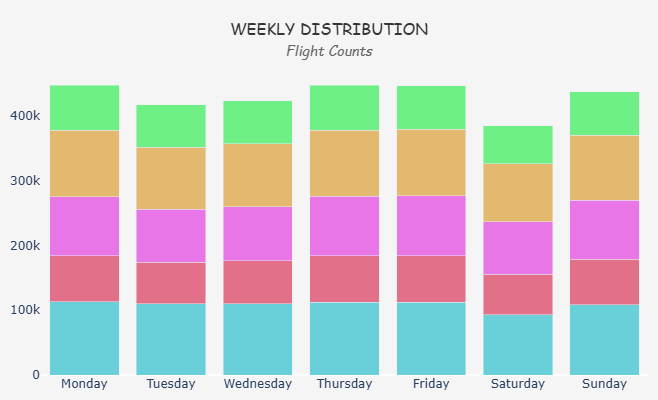

In [11]:
dow_order = ["Monday","Tuesday","Wednesday","Thursday",
             "Friday","Saturday","Sunday"]

df_dow = (
    df_flights
    .group_by(["YEAR", "DAY_OF_WEEK"])
    .agg(pl.len().alias("n_flights"))
    .with_columns(
        pl.col("DAY_OF_WEEK")
            .cast(pl.Utf8)
            .replace({str(k): v for k, v in dow_map.items()})
            .alias("DAY"),
        pl.col("YEAR").cast(pl.Utf8)
    )
    .sort(["YEAR", "DAY_OF_WEEK"])
)

year_colors = {
    "2019": "#47c6d1", 
    "2020": "#de506f",  
    "2021": "#e657e3", 
    "2022": "#deab4e", 
    "2023": "#4df06b",
}
fig_1 = px.bar(df_dow,
            x='DAY', y='n_flights',
            color='YEAR', color_discrete_map = year_colors,
            height=400, 
            color_discrete_sequence = px.colors.qualitative.Pastel)
fig_1.update_layout(barmode="stack", showlegend = False,
                  xaxis_title = None, yaxis_title = None,
                  yaxis=dict(showgrid=False),
                  title=dict(
                    text=(
                        "WEEKLY DISTRIBUTION"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig_1.update_xaxes(categoryorder = "array", categoryarray = dow_order)
fig_1.update_traces(opacity = 0.8)
fig_1.show()

### Chart: Airline Rankings

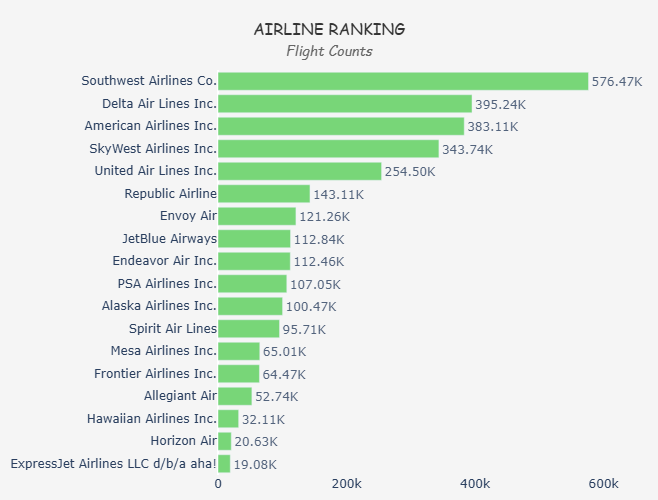

In [12]:
df_air_rank = (
    df_flights
    .group_by("AIRLINE")
    .agg(pl.len().alias("n_flights"))
    .sort("n_flights", descending=True)
    .with_columns(
        pl.col("n_flights")
        .map_elements(format_compact)
        .alias("text")
    )
    .to_pandas()
)

df_air_rank["text"] = df_air_rank["n_flights"].apply(format_compact)

fig_2 = px.bar(
    df_air_rank,
    x="n_flights", y="AIRLINE",
    orientation="h", text="text", 
    color_discrete_sequence=["#59cf5a"]  # màu tất cả bar
)
fig_2.update_layout(yaxis_title = None, xaxis_title=None,
                  yaxis=dict(autorange="reversed"), 
                  xaxis=dict(showgrid=False),                 
                  height = 500,
                  title=dict(
                    text=(
                        "AIRLINE RANKING"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=200, r=50, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
# Hiển thị text bên ngoài bar, cliponaxis để text xuất hiện đầy đủ
fig_2.update_traces(textposition='outside', cliponaxis=False,
                    opacity = 0.8)
fig_2.show()

### Chart: Monthly Departures

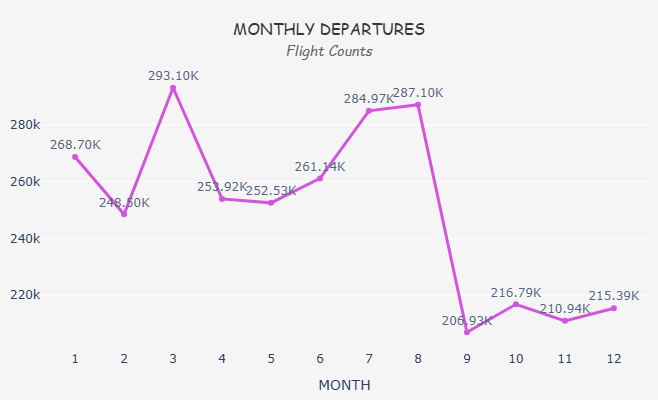

In [13]:
df_monthly_departures = (
    df_flights
    .group_by("MONTH")
    .agg(pl.len().alias("n_flights"))
    .sort("MONTH")
).to_pandas()

df_monthly_departures["text"] = df_monthly_departures["n_flights"].apply(format_compact)

fig_3 = px.line(df_monthly_departures,
              x='MONTH', y='n_flights',
              markers=True, text="text")
fig_3.update_layout(yaxis_title = None,  
                  xaxis=dict(showgrid=False), 
                  height = 400,
                  title=dict(
                    text=(
                        "MONTHLY DEPARTURES"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig_3.update_xaxes(
    tickmode="linear",
    tick0=1,
    dtick=1
)
# Hiển thị text ra ngoài điểm marker
fig_3.update_traces(
    textposition='top center',  # hoặc 'bottom center', 'middle right', 'middle left'
    opacity = 0.8, cliponaxis=False, # cliponaxis để text xuất hiện đầy đủ
    line=dict(color="#c82fd6", width=3),
)
fig_3.show()

*Note: Data for 2023 available through August only*

### Chart: Flight Distance Distribution

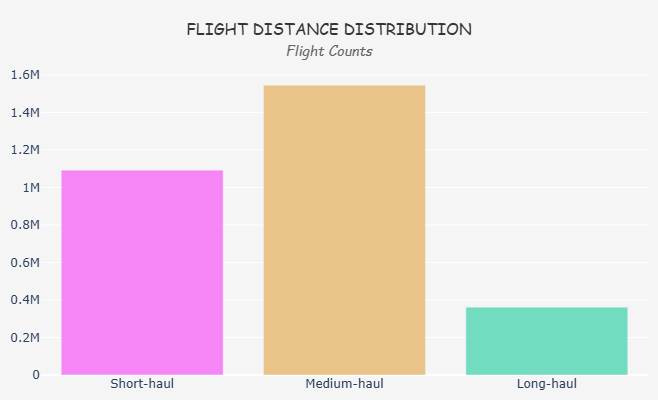

In [14]:
df_distance_departures = (
    df_flights
    .group_by("DISTANCE_CAT")
    .agg(pl.len().alias("n_flights")).sort("DISTANCE_CAT")
)

distance_colors = {
    "Short-haul": "#f76af7",
    "Medium-haul": "#e8b76d",
    "Long-haul": "#51d6b3"
}

fig_4 = px.bar(df_distance_departures,
            x='DISTANCE_CAT', y='n_flights',
            color='DISTANCE_CAT', color_discrete_map = distance_colors,
            height=400)

fig_4.update_layout(showlegend = False,
                  xaxis_title = None, yaxis_title = None,
                  title=dict(
                    text=(
                        "FLIGHT DISTANCE DISTRIBUTION"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig_4.update_traces(opacity = 0.8)
fig_4.update_xaxes(
    categoryorder="array",
    categoryarray=["Short-haul", "Medium-haul", "Long-haul"]
)
fig_4.show()

### Chart: National Coverage

In [15]:
df_flights = df_flights.with_columns([
    pl.concat_str([pl.col("ORIGIN_CITY"), pl.lit(" ("), 
                   pl.col("ORIGIN"), pl.lit(")")]).alias("ORIGIN_AIRPORT")
])

df_origin_airport = (
    df_flights
    .filter(pl.col("ORIGIN_LAT").is_not_null() 
            & pl.col("ORIGIN_LON").is_not_null())
    .group_by(["ORIGIN_AIRPORT", "ORIGIN_LAT", "ORIGIN_LON"])
    .agg(pl.len().alias("n_flights"))
).to_pandas() # convert to pandas to create map

df_origin_airport['text'] = df_origin_airport['n_flights'].apply(format_compact)

# create central map by mean of lat, lon
map_center = [df_origin_airport['ORIGIN_LAT'].mean(), 
              df_origin_airport['ORIGIN_LON'].mean()]
origin_map = folium.Map(location=map_center, zoom_start=4)

# Preparing data for heatmap: [lat, lon, weight]
heat_data = [[row['ORIGIN_LAT'], row['ORIGIN_LON'], row['n_flights']] 
             for _, row in df_origin_airport.iterrows()]

# Add heatmap
HeatMap(heat_data, radius=10, blur=10, max_zoom=10,
        gradient={0.2: 'blue', 0.4: 'lime',
                  0.6: 'orange', 0.8: 'red'}
       ).add_to(origin_map)

# Add invisible CircleMarker to hover tooltip
for _, row in df_origin_airport.iterrows():
    folium.CircleMarker(
        location=[row['ORIGIN_LAT'], row['ORIGIN_LON']],
        radius=0.1,  # almost hide
        tooltip=f"{row['ORIGIN_AIRPORT']}: {row['text']} flights",
        fill=True, fill_opacity=0
    ).add_to(origin_map)
origin_map # convert to pandas to create map

## 3.2 Operational Performance 
## 3.2.1 Overview + With/Without Filter

- On-time rate = Number of on-time flights / Total number of <b>operated flights</b> * 100
> Note: <b>Canceled and diverted flights</b> are typically excluded from the on-time performance calculation but included in the total pool of flight for overall performance metrics.
- Delay rate = Number of delayed flights / Total number of <b>operated flights</b> * 100
> This is often simply "<b>100% - Ontime Rate - Canceled Rate - Divert Rate</b>", as every flight falls into one of these categories. The average delay time in minutes is another common metric.
- Cancelled rate = Number of canceled flights / Total number of <b>scheduled flights</b> * 100
- Divert rate = Number of diverted flights / Total number of <b>scheduled flights</b> * 100

### On-time Performance & Delays

In [16]:
def ontime_delay_summary(df, year=None, airline=None):
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)

    total_flights = df.height

    total_cancelled = df.filter(pl.col("CANCELLED") == 1).height
    total_diverted  = df.filter(pl.col("DIVERTED") == 1).height

    total_operated = total_flights - total_cancelled - total_diverted

    total_on_time = df.filter(
        (pl.col("DEP_DELAY") <= 15) &
        (pl.col("CANCELLED") == 0) &
        (pl.col("DIVERTED") == 0)
    ).height

    total_delayed = total_operated - total_on_time

    pct_cancelled = round(total_cancelled / total_flights * 100, 2)
    pct_diverted  = round(total_diverted / total_flights * 100, 2)
    pct_operated  = round(total_operated / total_flights * 100, 2)
    pct_on_time   = round(total_on_time / total_operated * 100, 2)
    pct_delayed   = round(total_delayed / total_operated * 100, 2)

    print("On-time Performance & Delays")
    print(
        f"Years: {year if year else '2019–2023'} | "
        f"Airlines: {airline if airline else 'All'}\n"
    )
    print(f"Total flights: {total_flights}")
    print(f"Cancelled: {pct_cancelled}%")
    print(f"Diverted: {pct_diverted}%")
    print(f"Operated flights: {pct_operated}%")
    print(f"  - On-time: {pct_on_time}% of operated")
    print(f"  - Delayed: {pct_delayed}% of operated")

In [17]:
ontime_delay_summary(df_flights)

On-time Performance & Delays
Years: 2019–2023 | Airlines: All

Total flights: 3000000
Cancelled: 2.64%
Diverted: 0.24%
Operated flights: 97.13%
  - On-time: 82.47% of operated
  - Delayed: 17.53% of operated


In [18]:
ontime_delay_summary(df_flights, year = 2019)

On-time Performance & Delays
Years: 2019 | Airlines: All

Total flights: 757673
Cancelled: 1.79%
Diverted: 0.26%
Operated flights: 97.94%
  - On-time: 82.01% of operated
  - Delayed: 17.99% of operated


In [19]:
ontime_delay_summary(df_flights, year = 2019, airline = "United Air Lines Inc.")

On-time Performance & Delays
Years: 2019 | Airlines: United Air Lines Inc.

Total flights: 63572
Cancelled: 0.84%
Diverted: 0.33%
Operated flights: 98.83%
  - On-time: 81.46% of operated
  - Delayed: 18.54% of operated


### Chart: MONTHLY DISTRIBUTION OF ON-TIME & DELAYED FLIGHTS

In [20]:
def monthly_ontime_delay(df, year=None, airline=None):
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)

    df_monthly = ontime_delay_by(df, ["MONTH"])

    fig = px.bar(
        df_monthly,
        x="MONTH",
        y=["n_ontime", "n_delayed"],
        labels={
            "value": "Number of operated flights",
            "variable": "Status"
        },
        height=400,
        color_discrete_sequence=px.colors.qualitative.Pastel
    )

    fig.update_layout(
        barmode="stack",
        showlegend=False,
        xaxis=dict(dtick=1),
        yaxis_title=None,
        title=dict(
            text=(
                "MONTHLY DISTRIBUTION OF ON-TIME & DELAYED FLIGHTS"
                "<br><span style='font-size:14px;color:#666;font-style:italic'>Operated Flight Volume</span>"
            ),
            x=0.5,
            xanchor="center"
        ),
        margin=dict(l=10, r=10, t=70, b=10),
        paper_bgcolor="#f5f5f5",
        plot_bgcolor="#f5f5f5",
        title_font=dict(size=16, color="#333", family="Comic Sans MS")
    )

    fig.update_traces(opacity=0.8)
    fig.show()

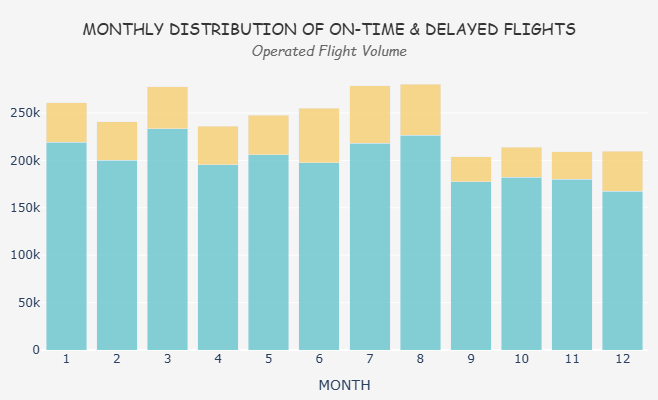

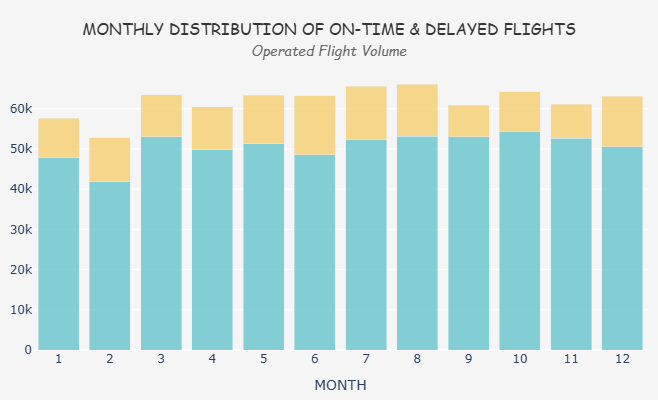

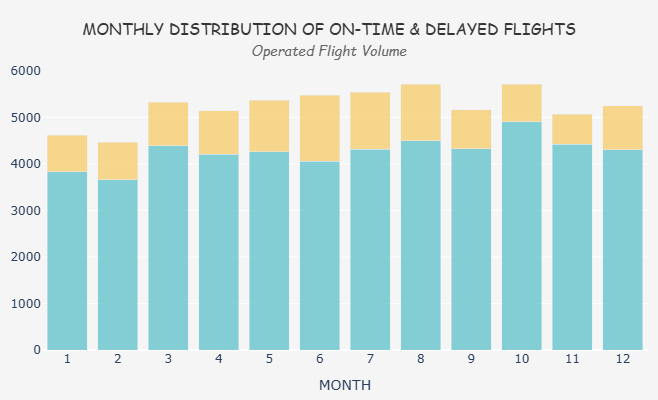

In [21]:
monthly_ontime_delay(df_flights)
monthly_ontime_delay(df_flights, year = 2019)
monthly_ontime_delay(df_flights, year = 2019, airline = "United Air Lines Inc.")

### Chart: MONTHLY FLIGHT VOLUME VS AVERAGE DELAY

In [22]:
def monthly_volume_delay(df, year=None, airline=None):
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)

    df_monthly_perf = (
        ontime_delay_by(df, ["MONTH"])
        .select(["MONTH", "n_operated", "avg_delay"]).to_pandas()
    )

    df_monthly_perf["text"] = df_monthly_perf["n_operated"].apply(format_compact)
    df_monthly_perf["avg_delay"] = df_monthly_perf["avg_delay"].round(1)

    fig = go.Figure()

    # Bar: number of flights
    fig.add_bar(
        x=df_monthly_perf["MONTH"], y=df_monthly_perf["n_operated"],
        name="Number of Flights", yaxis="y",
        text=df_monthly_perf["text"], textposition="outside", opacity=0.65,    
        hovertemplate=(
            "<b>Month:</b> %{x}<br>"
            "<b>Flights:</b> %{y:,}<br>"
            "<extra></extra>"
        ),
        marker=dict(color="#D97706"),
    )
    
    # Line: average delay
    fig.add_trace(
        go.Scatter(
            x=df_monthly_perf["MONTH"], y=df_monthly_perf["avg_delay"],
            name="Avg Departure Delay (min)",
            mode="lines+markers",
            yaxis="y2", 
            line=dict(
                color="#2563EB",
                width=2, dash="dash"   # 👈 nét đứt
            ),
            marker=dict(size=8),
        )
    )
    
    fig.update_layout(
        xaxis = dict(type="category", showgrid=False),
        yaxis = dict(title="Number of Flights", showgrid=False),
        yaxis2 = dict(title="Avg Delay (minutes)", 
                      overlaying="y", side="right", showgrid=False), 
        showlegend = False,
        title=dict(
            text=("MONTHLY FLIGHT VOLUME VS AVERAGE DELAY"),
            x=0.5, xanchor="center"
        ),
        margin = dict(l=10, r=10, t=70, b=10),
                      paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                      plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                      title_font=dict(size=16, color="#333", family="Comic Sans MS")
    )
    fig.update_traces(cliponaxis=False)
    fig.show()

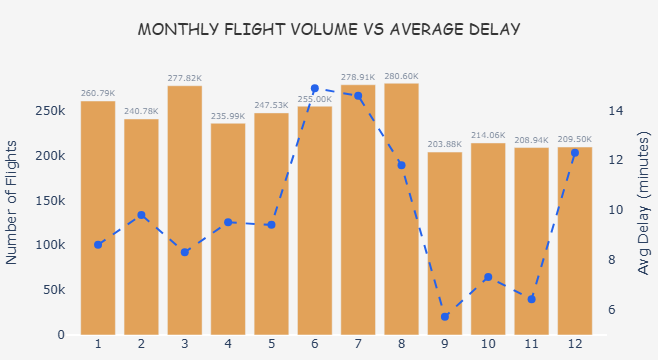

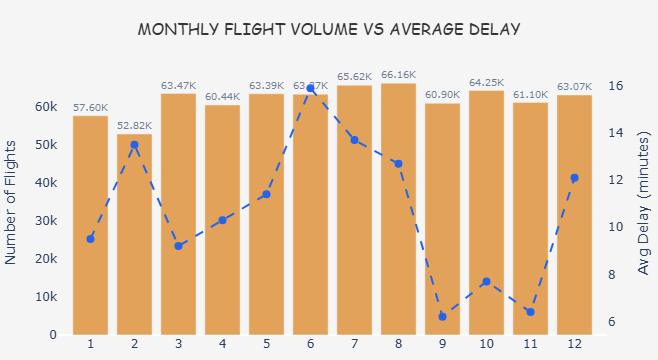

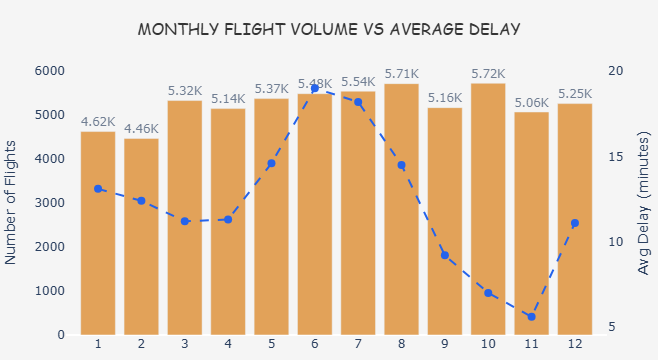

In [23]:
monthly_volume_delay(df_flights)
monthly_volume_delay(df_flights, year = 2019)
monthly_volume_delay(df_flights, year = 2019, airline = "United Air Lines Inc.")

### Chart: Delay Causes

In [24]:
def delay_causes(df, year=None, airline=None):
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)

    df = df.filter(
        (pl.col("CANCELLED") == 0) &
        (pl.col("DIVERTED") == 0)
    )
    
    delay_cols = [
        "DELAY_DUE_CARRIER",
        "DELAY_DUE_WEATHER",
        "DELAY_DUE_NAS",
        "DELAY_DUE_SECURITY",
        "DELAY_DUE_LATE_AIRCRAFT"
    ]
    
    cause_map = {
        "DELAY_DUE_LATE_AIRCRAFT": "Late Aircraft",
        "DELAY_DUE_NAS": "NAS",
        "DELAY_DUE_CARRIER": "Carrier",
        "DELAY_DUE_WEATHER": "Weather",
        "DELAY_DUE_SECURITY": "Security"
    }
    
    df_delay_causes = (
        df
        .select(delay_cols).sum()
        .transpose(include_header=True)
        .rename({"column": "cause", "column_0": "delay_minutes"})
        .with_columns([
            (pl.col("delay_minutes") / pl.col("delay_minutes").sum() * 100).alias("pct"),
            pl.col("cause").replace(cause_map).alias("label")
        ])
        .with_columns(
            pl.col("pct").round(0).cast(pl.Int64).alias("n_blocks")
        )
    )
    
    # Fix rounding để tổng = 100
    diff = 100 - df_delay_causes["n_blocks"].sum()
    if diff != 0:
        idx = df_delay_causes["n_blocks"].arg_max()
        df_delay_causes = df_delay_causes.with_row_index("_i")
        df_delay_causes = df_delay_causes.with_columns(
            pl.when(pl.col("_i") == idx)
              .then(pl.col("n_blocks") + diff)
              .otherwise(pl.col("n_blocks"))
              .alias("n_blocks")
        ).drop("_i")
    
    df_delay_causes_pd = df_delay_causes.sort("pct", descending=True).to_pandas()

    labels = df_delay_causes_pd["label"].tolist()
    blocks = df_delay_causes_pd["n_blocks"].tolist()
    
    waffle = []
    for label, n in zip(labels, blocks):
        waffle.extend([label] * n)
    
    rows, cols = 5, 20
    x = np.tile(np.arange(cols), rows)
    y = np.repeat(np.arange(rows)[::-1], cols)

    color_map = {
    "Late Aircraft": "#FDBA74",  # pastel orange
    "NAS": "#93C5FD",            # pastel blue
    "Carrier": "#86EFAC",        # pastel green
    "Weather": "#FCA5A5",        # pastel red
    "Security": "#D1D5DB"        # pastel gray
    }

    fig = go.Figure()
    
    for cause, color in color_map.items():
        mask = np.array([c == cause for c in waffle])
    
        pct = df_delay_causes_pd.loc[
            df_delay_causes_pd["label"] == cause, "pct"
        ].values[0]
    
        fig.add_trace(
            go.Scatter(
                x = x[mask], y = y[mask],
                mode="markers",
                name=cause,
                marker=dict(
                    size=22, symbol = "square",
                    color=color, line = dict(width=1, color="#f5f5f5")
                ),
                hovertemplate=(
                    f"<b>{cause}</b><br>"
                    f"{pct:.1f}% of total delay<br>"
                    "<extra></extra>"
                )
            )
        )
    
    fig.update_layout(
        title=dict(
            text=(
                "Flight Delay Breakdown by Causes"
                "<br><span style='font-size:14px;color:#666;font-style:italic'>"
                "Share of Total Delay Minutes"
                "</span>"
            ),
            x=0.5, xanchor="center"
        ),
    
        legend=dict(
            orientation="h",
            yanchor = "top", y = 1.2,
            xanchor = "center", x = 0.5,
            font=dict(size=12), title=None
        ),
    
        height=320,
        margin=dict(l=20, r=20, t=140, b=20),
    
        xaxis=dict(visible=False, range=[-0.5, 19.5]),
        yaxis=dict(visible=False, range=[-0.5, 4.5]),
    
        paper_bgcolor="#f5f5f5",
        plot_bgcolor="#f5f5f5",
        showlegend=True
    )
    
    fig.show()

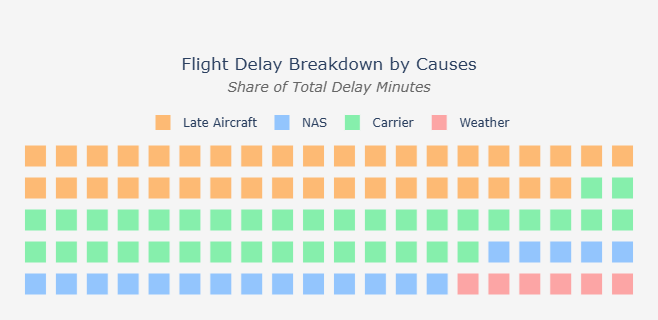

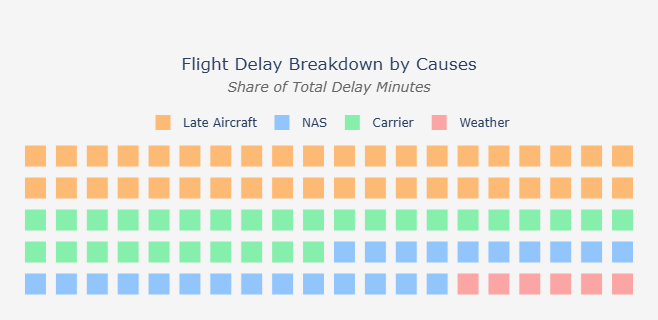

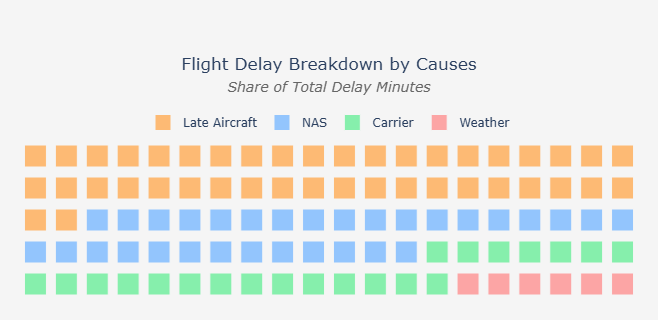

In [25]:
delay_causes(df_flights)
delay_causes(df_flights, year = 2019)
delay_causes(df_flights, year = 2019, airline = "United Air Lines Inc.")

## 3.2.2 Local Patterns

### SUMMARY

In [26]:
def local_patterns(df, year=None, airline=None,
                   origin_airport=None, season=None):

    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if origin_airport is not None:
        df = df.filter(pl.col("ORIGIN") == origin_airport)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)

    total_flights = df.height

    df_operated = df.filter(
        (pl.col("CANCELLED") == 0) &
        (pl.col("DIVERTED") == 0)
    )

    avg_dep = df_operated.select(pl.mean("DEP_DELAY")).item()
    avg_arr = df_operated.select(pl.mean("ARR_DELAY")).item()

    ontime_rate = (
        df_operated
        .select((pl.col("DEP_DELAY") <= 15).mean() * 100)
        .item()
    )

    print(f"Total flights: {total_flights}")
    print(f"On-time rate: {ontime_rate:.1f}%")
    print(f"Avg departure delay: {avg_dep:.1f} min")
    print(f"Avg arrival delay: {avg_arr:.1f} min")

In [27]:
local_patterns(df_flights)
local_patterns(df_flights, year = 2019)
local_patterns(df_flights, year = 2019, airline = "United Air Lines Inc.")
local_patterns(df_flights, year = 2019, airline = "United Air Lines Inc.", origin_airport = "DEN")
local_patterns(df_flights, year = 2019, airline = "United Air Lines Inc.", origin_airport = "DEN", season = "Summer")

Total flights: 3000000
On-time rate: 82.5%
Avg departure delay: 10.1 min
Avg arrival delay: 4.3 min
Total flights: 757673
On-time rate: 82.0%
Avg departure delay: 10.7 min
Avg arrival delay: 5.3 min
Total flights: 63572
On-time rate: 81.5%
Avg departure delay: 12.3 min
Avg arrival delay: 7.7 min
Total flights: 6925
On-time rate: 80.5%
Avg departure delay: 12.0 min
Avg arrival delay: 8.0 min
Total flights: 1871
On-time rate: 73.5%
Avg departure delay: 19.3 min
Avg arrival delay: 15.3 min


### Table: AIRPORT DELAY STABILITY

In [28]:
def airport_delay_stability(df, min_flights=1000,
                            year=None, airline=None, season=None):

    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)

    df_airport = (
        df
        .filter((pl.col("CANCELLED") == 0) & (pl.col("DIVERTED") == 0))
        .group_by("ORIGIN")
        .agg([
            pl.len().alias("n_flights"),
            pl.mean("ARR_DELAY").alias("avg_arr_delay"),
            pl.std("ARR_DELAY").alias("std_arr_delay"),
            (pl.col("ARR_DELAY") <= 15).mean().alias("ontime_rate")
        ])
        .filter(pl.col("n_flights") >= min_flights)
        .with_columns(
            (pl.col("ontime_rate") * 100).round(1)
        )
        .sort("std_arr_delay", descending=True)
    )

    return df_airport.to_pandas()

In [29]:
df_stability = airport_delay_stability(df_flights, year = 2019)
df_stability.head(10)

,ORIGIN,n_flights,avg_arr_delay,std_arr_delay,ontime_rate
0,MSN,1428,10.235294,80.958159,82.5
1,SDF,2489,7.745681,80.140557,82.5
2,FAT,1234,6.525932,71.974548,84.2
3,SJU,2619,9.066819,70.431138,80.4
4,LIT,1373,10.136198,69.869201,80.4
5,CHS,2568,6.326713,69.398301,83.1
6,RIC,2394,5.284461,68.849914,81.7
7,HPN,1149,9.923412,67.228012,78.8
8,ELP,1700,4.755294,66.531658,85.2
9,PBI,2566,8.326189,65.409724,80.5


### Table: ROUTING RANKING

In [30]:
def routing_ranking(df, min_flights=200,
                    year=None, airline=None, season=None):

    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)

    df_route = (
        df
        .filter((pl.col("CANCELLED") == 0) & (pl.col("DIVERTED") == 0))
        .group_by("ROUTE")
        .agg([
            pl.len().alias("n_flights"),
            pl.mean("ARR_DELAY").alias("avg_arr_delay"),
            pl.std("ARR_DELAY").alias("std_arr_delay"),
            (pl.col("ARR_DELAY") <= 15).mean().alias("ontime_rate")
        ])
        .filter(pl.col("n_flights") >= min_flights)
        .with_columns(
            (pl.col("ontime_rate") * 100).round(1)
        )
        .sort("std_arr_delay", descending=True)
    )

    return df_route.to_pandas()

In [31]:
df_route = routing_ranking(df_flights, year = 2019, airline = "United Air Lines Inc.")
df_route

,ROUTE,n_flights,avg_arr_delay,std_arr_delay,ontime_rate
0,"Orlando, FL → Newark, NJ",343,24.023324,125.539815,74.3
1,"Fort Lauderdale, FL → Newark, NJ",227,26.533040,110.646701,74.9
2,"Orlando, FL → Chicago, IL",204,10.073529,96.588352,80.4
3,"Seattle, WA → San Francisco, CA",277,11.046931,87.854466,80.1
4,"Newark, NJ → Los Angeles, CA",435,15.257471,84.771897,75.9
...,...,...,...,...,...
80,"San Francisco, CA → Houston, TX",325,3.800000,31.523654,80.6
81,"Houston, TX → Las Vegas, NV",232,1.775862,30.781618,86.2
82,"San Francisco, CA → Portland, OR",261,5.413793,29.516704,78.5
83,"Washington, DC → Houston, TX",267,0.146067,24.818992,82.0


### Chart: TIME OF DAY --> AVG ARRIVAL DELAY BY DEPARTURE HOUR

In [32]:
def time_of_day(df, year=None, airline=None, season=None):

    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)

    df_op = df.filter(
        (pl.col("CANCELLED") == 0) &
        (pl.col("DIVERTED") == 0)
    )

    group_cols = ["DEP_HOUR"]
    if year is None:
        group_cols = ["YEAR", "DEP_HOUR"]

    delay_hourly = (
        df_op
        .group_by(group_cols)
        .agg([
            pl.mean("DEP_DELAY").round(1).alias("avg_dep_delay"),
            (pl.col("DEP_DELAY") <= 15).mean().alias("ontime_rate")
        ])
        .with_columns(
            (pl.col("ontime_rate") * 100).round(1)
        )
        .sort(group_cols)
    )

    fig = px.line(
        delay_hourly.to_pandas(),
        x="DEP_HOUR",
        y="avg_dep_delay",
        color="YEAR" if year is None else None,
        line_shape="hv",
        markers=True,
        height=450
    )

    fig.update_layout(
        showlegend=False,
        xaxis=dict(dtick=1, type="category"),
        yaxis_title=None,
        title=dict(
            text="AVERAGE DEPARTURE DELAY BY TIME OF DAY",
            x=0.5
        ),
        margin=dict(l=10, r=10, t=70, b=10),
        paper_bgcolor="#f5f5f5",
        plot_bgcolor="#f5f5f5",
        title_font=dict(size=16, color="#333", family="Comic Sans MS")
    )

    fig.show()

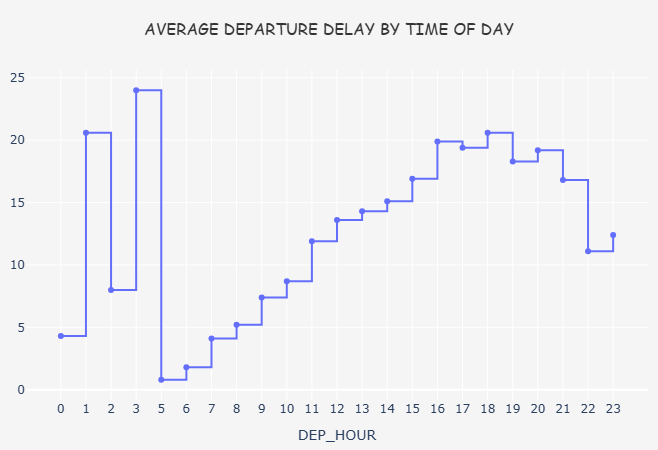

In [33]:
time_of_day(df_flights, year = 2019, airline = "United Air Lines Inc.")

### Map: Arrival delay by airport

In [34]:
def arrival_delay_folium(df, year=None, airline=None,
                season=None, volume_quantile=0.7,   # giữ top ~30% airport theo volume
                tiles="CartoDB positron"):
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)


    df = (
        df
        .filter(pl.col("CANCELLED") == 0)
        .filter(pl.col("DIVERTED") == 0)
        .filter(pl.col("ARR_DELAY").is_not_null())
        .drop_nulls(["DEST_LAT", "DEST_LON"])
    )

    # --- aggregate (median = ít nhiễu) ---
    airport_perf = (
        df
        .group_by(["DEST", "DEST_LAT", "DEST_LON"])
        .agg(
            pl.len().alias("n_flights"),
            pl.col("ARR_DELAY").median().round(1).alias("med_arr_delay"),
            (pl.col("ARR_DELAY") <= 15).mean().alias("ontime_rate")
        )
        .with_columns(
            (pl.col("ontime_rate") * 100).round(1)
        )
    )

    # --- percentile filter (không hard threshold) ---
    q = airport_perf.select(
        pl.col("n_flights").quantile(volume_quantile)
    ).item()

    airport_perf = airport_perf.filter(pl.col("n_flights") >= q)
    df_map = airport_perf.to_pandas()

    m = folium.Map(
        location=[39.5, -98.35],
        zoom_start=4,
        tiles=tiles
    )

    cluster = MarkerCluster().add_to(m)

    colormap = LinearColormap(
        colors=["green", "yellow", "red"],
        vmin=df_map["med_arr_delay"].min(),
        vmax=df_map["med_arr_delay"].max(),
        caption="Median Arrival Delay (min)"
    )

    for _, r in df_map.iterrows():
        folium.CircleMarker(
            location=[r["DEST_LAT"], r["DEST_LON"]],
            radius=max(2, min(r["n_flights"] / 30000, 9)),
            color=colormap(r["med_arr_delay"]),
            fill=True,
            fill_color=colormap(r["med_arr_delay"]),
            fill_opacity=0.6,
            weight=0,
            tooltip=(
                f"<b>{r['DEST']}</b><br>"
                f"Median Arrival Delay: {r['med_arr_delay']} min<br>"
                f"On-time rate: {r['ontime_rate']}%<br>"
                f"Flights: {r['n_flights']:,}"
            )
        ).add_to(cluster)

    colormap.add_to(m)

    return m

In [35]:
m = arrival_delay_folium(df_flights, year = 2019, season="Winter")
m

## 3.2.3 Delay Factors & Interactions

### Chart: INFLUENCE OF VARIOUS DELAYS

In [36]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt


def delay_contribution(df, year=None, airline=None, season=None):
    """
    Show contribution (%) of different delay causes
    to total delay minutes (EDA purpose only).
    """

    delay_cols = [
        "DELAY_DUE_CARRIER",
        "DELAY_DUE_WEATHER",
        "DELAY_DUE_NAS",
        "DELAY_DUE_SECURITY",
        "DELAY_DUE_LATE_AIRCRAFT",
    ]

    # ---- filters ----
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)

    df = df.filter(
        (pl.col("CANCELLED") == 0) &
        (pl.col("DIVERTED") == 0)
    )

    # ---- aggregate: total delay minutes ----
    values = (
        df
        .select(delay_cols)
        .select(pl.all().sum())
        .row(0)
    )

    values = np.array(values, dtype=float)

    # handle edge case: no delay
    if values.sum() == 0:
        print("No delay minutes available for selected filters.")
        return

    rel = values / values.sum()   # contribution %

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(4.2, 5))

    im = ax.imshow(
        rel.reshape(-1, 1),
        aspect="auto",
        vmin=0, vmax=rel.max(),
        cmap="Spectral"
    )

    labels = [
        "Carrier",
        "Weather",
        "NAS",
        "Security",
        "Late Aircraft"
    ]

    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xticks([])

    # annotate values
    for i, v in enumerate(rel):
        ax.text(
            0, i, f"{v*100:.1f}%",
            ha="center", va="center",
            color="white" if v > 0.15 else "black",
            fontsize=9
        )

    title_parts = ["Contribution to Total Delay Minutes"]
    if year is not None:
        title_parts.append(f"Year: {year}")
    if airline is not None:
        title_parts.append(f"Airline: {airline}")
    if season is not None:
        title_parts.append(f"Season: {season}")

    ax.set_title(" | ".join(title_parts), fontsize=11, pad=10)

    plt.colorbar(im, ax=ax, fraction=0.05, pad=0.04, label="Share")
    plt.tight_layout()
    plt.show()

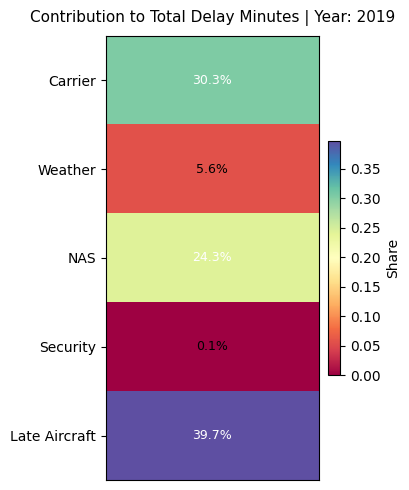

In [37]:
delay_contribution(df_flights, year = 2019)

### Chart: Marginal Effect of Delay

In [38]:
def delay_factor_interaction(df, year=None, airline=None, season=None):
    """
    EDA: marginal relationship between delay causes
    and mean arrival delay.
    """

    delay_cols = [
        "DELAY_DUE_CARRIER",
        "DELAY_DUE_WEATHER",
        "DELAY_DUE_NAS",
        "DELAY_DUE_SECURITY",
        "DELAY_DUE_LATE_AIRCRAFT"
    ]

    # ---- filters ----
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)

    df = df.filter(
        (pl.col("CANCELLED") == 0) &
        (pl.col("DIVERTED") == 0) &
        (pl.col("ARR_DELAY").is_not_null())
    )

    # ---- long format ----
    long_df = df.unpivot(
        index=["ARR_DELAY"],
        on=delay_cols,
        variable_name="factor",
        value_name="delay_value"
    )

    # ---- bin delay magnitude ----
    long_df = long_df.with_columns(
        pl.when(pl.col("delay_value") <= 0).then(pl.lit("0"))
         .when(pl.col("delay_value") <= 5).then(pl.lit("1–5"))
         .when(pl.col("delay_value") <= 15).then(pl.lit("5–15"))
         .when(pl.col("delay_value") <= 30).then(pl.lit("15–30"))
         .otherwise(pl.lit(">30"))
         .alias("delay_bin")
    )

    # ---- aggregate ----
    summary = (
        long_df
        .group_by(["factor", "delay_bin"])
        .agg(
            pl.mean("ARR_DELAY").round(1).alias("mean_arr_delay"),
            pl.len().alias("n_flights")
        )
        .filter(pl.col("n_flights") > 1000)   # stability
    )

    summary_pd = summary.to_pandas()

    # ---- plot ----
    fig = px.line(
        summary_pd,
        x="delay_bin",
        y="mean_arr_delay",
        facet_col="factor",
        facet_col_wrap=3,
        markers=True,
        category_orders={
            "delay_bin": ["0", "1–5", "5–15", "15–30", ">30"]
        },
        title="Marginal Effect of Delay Causes on Arrival Delay"
    )

    fig.update_layout(
        height=800,
        showlegend=False,
        paper_bgcolor="#f5f5f5",
        plot_bgcolor="#f5f5f5"
    )

    fig.update_yaxes(title="Mean Arrival Delay (minutes)")
    fig.update_xaxes(title="Delay Magnitude Bin")

    fig.show()

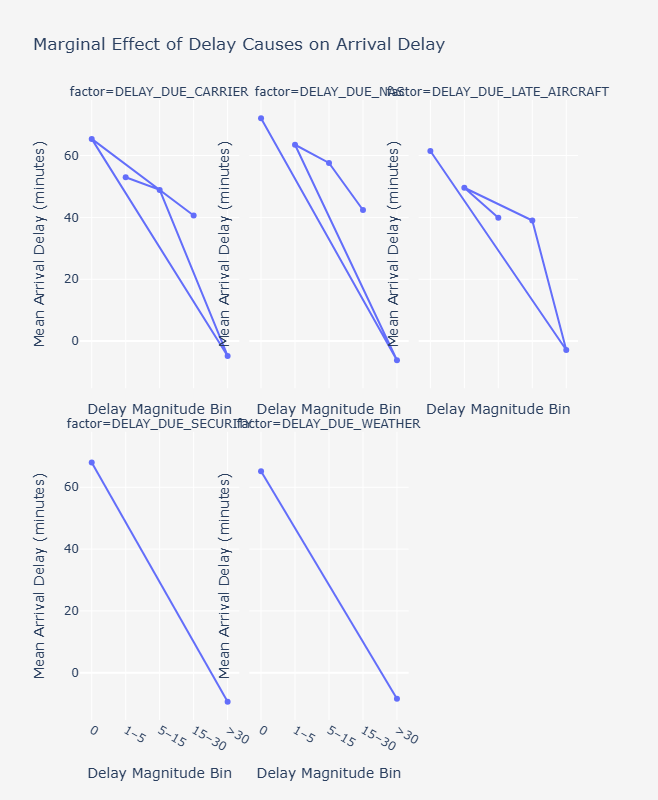

In [39]:
delay_factor_interaction(df_flights, year = 2019, season = "Spring")

## 3.2.4 Disruption Analysis
## Summary

In [40]:
def disruption_metrics(df, year=None, airline=None, season=None):
    if year is not None:
        df = df.filter(pl.col("YEAR") == year)
    if airline is not None:
        df = df.filter(pl.col("AIRLINE") == airline)
    if season is not None:
        df = df.filter(pl.col("SEASON") == season)

    total_flights = df.height
    if total_flights == 0:
        print("No flights after filtering.")
        return

    cancelled = df.select(pl.sum("CANCELLED")).item()
    diverted = df.select(pl.sum("DIVERTED")).item()
    disrupted = cancelled + diverted

    print("📊 Disruption Summary")
    print("-" * 30)
    print(f"Total flights: {total_flights:,}")
    print(f"Cancelled flights: {cancelled / total_flights:.2%}")
    print(f"Diverted flights: {diverted / total_flights:.2%}")
    print(f"Total disrupted: {disrupted / total_flights:.2%}")

In [41]:
disruption_metrics(df_flights, season="Winter")

📊 Disruption Summary
------------------------------
Total flights: 732,588
Cancelled flights: 2.72%
Diverted flights: 0.22%
Total disrupted: 2.94%


### Chart: Disruption Rate Over Time

In [42]:
def plot_disruption_bar(df, year=None, airline=None, season=None):
    df_filtered = df
    if year is not None:
        if isinstance(year, int):
            year = [year]
        df_filtered = df_filtered.filter(pl.col("YEAR").is_in(year))
    if airline is not None:
        if isinstance(airline, str):
            airline = [airline]
        df_filtered = df_filtered.filter(pl.col("AIRLINE").is_in(airline))
    if season is not None:
        if isinstance(season, str):
            season = [season]
        df_filtered = df_filtered.filter(pl.col("SEASON").is_in(season))
    
    df_disruption = (
        df_filtered
        .with_columns(
            pl.when(pl.col("CANCELLED") == 1).then(pl.lit("Cancelled"))
            .when(pl.col("DIVERTED") == 1).then(pl.lit("Diverted"))
            .otherwise(None)
            .alias("DISRUPTION_TYPE")
        )
        .filter(pl.col("DISRUPTION_TYPE").is_not_null())
    )
    
    df_grouped = (
        df_disruption
        .group_by(["YEAR", "SEASON", "DISRUPTION_TYPE"])
        .agg(pl.len().alias("COUNT"))
        .sort(["YEAR", "SEASON"])
    )
    
    total_per_year = df_filtered.group_by("YEAR").agg(pl.len().alias("TOTAL"))
    df_grouped = df_grouped.join(total_per_year, on="YEAR")
    df_grouped = df_grouped.with_columns(
        (pl.col("COUNT") / pl.col("TOTAL") * 100).alias("RATE")
    )
    
    fig = px.bar(
        df_grouped.to_pandas(),
        x="YEAR",            # dùng YEAR numeric
        y="RATE",
        color="DISRUPTION_TYPE",
        barmode="stack",
        facet_col="SEASON",
        title="Flight Disruption Rate Over Time (Cancelled vs Diverted)",
        labels={
            "YEAR": "Year",
            "RATE": "Disruption Rate (%)",
            "DISRUPTION_TYPE": "Disruption Type",
            "SEASON": "Season"
        }
    )
    
    # Hover template
    fig.update_traces(
        hovertemplate="Year: %{x}<br>Season: %{facet_col}<br>Type: %{legendgroup}<br>Rate: %{y:.2f}%<extra></extra>"
    )
    
    # Layout tweak
    fig.update_layout(
        xaxis_title="Year",
        yaxis_title="Disruption Rate (%)",
        legend_title="Disruption Type",
        height=500
    )
    
    fig.show()

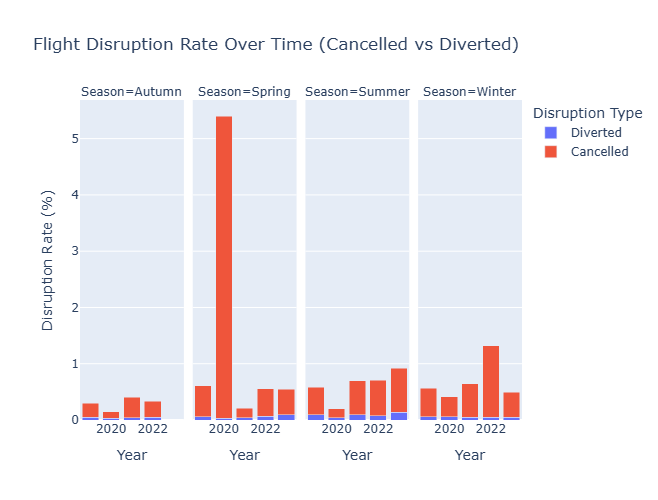

In [43]:
plot_disruption_bar(df_flights)

### Chart: Share of Disruption Causes

In [44]:
def plot_cause_donut(df, year=None, airline=None, season=None):
    # --- inline filtering ---
    if year is not None:
        if isinstance(year, int):
            year = [year]
        df = df.filter(pl.col("YEAR").is_in(year))

    if airline is not None:
        if isinstance(airline, str):
            airline = [airline]
        df = df.filter(pl.col("AIRLINE").is_in(airline))

    if season is not None:
        if isinstance(season, str):
            season = [season]
        df = df.filter(pl.col("SEASON").is_in(season))

    # --- delay components ---
    delay_cols = [
        "DELAY_DUE_CARRIER",
        "DELAY_DUE_WEATHER",
        "DELAY_DUE_NAS",
        "DELAY_DUE_SECURITY",
        "DELAY_DUE_LATE_AIRCRAFT"
    ]

    label_map = {
        "DELAY_DUE_CARRIER": "Carrier",
        "DELAY_DUE_WEATHER": "Weather",
        "DELAY_DUE_NAS": "NAS",
        "DELAY_DUE_SECURITY": "Security",
        "DELAY_DUE_LATE_AIRCRAFT": "Late Aircraft"
    }

    # --- only delayed flights ---
    df_delay = df.filter(pl.col("ARR_DELAY") > 0)

    # --- long format ---
    df_long = (
        df_delay
        .select(delay_cols)
        .unpivot(on=delay_cols)
        .rename({"variable": "CAUSE", "value": "DELAY_MIN"})
        .filter(pl.col("DELAY_MIN") > 0)
    )

    # --- aggregate ---
    summary = (
        df_long
        .group_by("CAUSE")
        .agg(pl.sum("DELAY_MIN").alias("TOTAL_DELAY"))
        .with_columns(
            (pl.col("TOTAL_DELAY") / pl.col("TOTAL_DELAY").sum() * 100)
            .round(2)
            .alias("RATE"),
            pl.col("CAUSE").replace(label_map).alias("CAUSE_LABEL")
        )
        .sort("RATE", descending=True)
    )

    # --- pull largest slice ---
    pull = [0.08 if i == 0 else 0 for i in range(summary.height)]

    # --- donut chart ---
    fig = px.pie(
        summary.to_pandas(),
        names="CAUSE_LABEL",
        values="RATE",
        hole=0.5,
        title="Delay Cause Breakdown<br><span style='font-size:13px;color:#666'>Share of total delay minutes</span>"
    )

    fig.update_traces(
        textinfo="label+percent",
        hovertemplate="%{label}: %{value:.2f}%<extra></extra>",
        marker=dict(line=dict(color="white", width=2)),
        pull=pull,
        showlegend=False
    )

    fig.update_layout(
        height=420,
        margin=dict(l=20, r=20, t=80, b=20),
        paper_bgcolor="#f5f5f5",
        plot_bgcolor="#f5f5f5",
        title_font=dict(size=16, color="#333", family="Comic Sans MS")
    )

    fig.show()

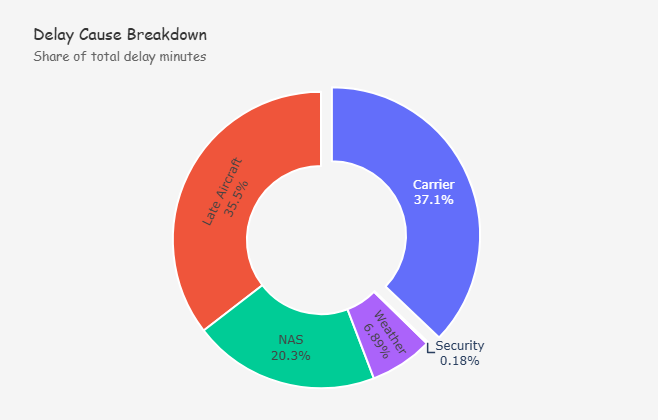

In [45]:
plot_cause_donut(df_flights, season="Winter")  

# 4. Predict

In [61]:
TIME_BINS = {
    "Morning": list(range(5, 12)),
    "Afternoon": list(range(12, 18)),
    "Evening": list(range(18, 24))
}

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

def risk_level(score):
    if score < 35:
        return "Low"
    elif score < 65:
        return "Medium"
    else:
        return "High"

def predict_delay_risk(
    df,
    airline_name=None,
    origin_airport_name=None,
    dest_airport_name=None,
    flight_date=None,
    time_of_day=None,
    min_flights=200
):
    print("✈️  FLIGHT DELAY RISK ASSESSMENT")
    print("=" * 42)

    scores = []
    details = []

    if flight_date:
        date_obj = datetime.strptime(flight_date, "%Y-%m-%d")
        day_name = date_obj.strftime("%A")
        is_weekend = day_name in ["Saturday", "Sunday"]
        season = get_season(date_obj.month)
        weekday_type = "Weekend" if is_weekend else "Weekday"
    else:
        day_name = season = weekday_type = None

    if airline_name:
        sub = df.filter(pl.col("AIRLINE") == airline_name)

        if sub.height == 0:
            print(f"❌ Airline not found: {airline_name}")
            return

        if sub.height >= min_flights:
            rate = sub.select((pl.col("ARR_DELAY") > 15).mean()).item()
            score = int(np.clip(rate * 120, 0, 100))
            scores.append(score)
            details.append(("Airline", airline_name, score))

    if origin_airport_name and dest_airport_name:
        sub = df.filter(
            (pl.col("ORIGIN_CITY") == origin_airport_name) &
            (pl.col("DEST_CITY") == dest_airport_name)
        )

        if sub.height == 0:
            print("❌ Invalid route (city pair not found)")
            return

        if sub.height >= min_flights:
            rate = sub.select((pl.col("ARR_DELAY") > 15).mean()).item()
            score = int(np.clip(rate * 130, 0, 100))
            scores.append(score)
            details.append((
                "Route",
                f"{origin_airport_name} → {dest_airport_name}",
                score
            ))

    if time_of_day in TIME_BINS:
        sub = df.filter(pl.col("DEP_HOUR").is_in(TIME_BINS[time_of_day]))

        if sub.height >= min_flights:
            rate = sub.select((pl.col("ARR_DELAY") > 15).mean()).item()
            score = int(np.clip(rate * 100, 0, 100))
            scores.append(score)
            details.append(("Time of Day", time_of_day, score))

    if season:
        sub = df.filter(pl.col("SEASON") == season)

        if sub.height >= min_flights:
            rate = sub.select((pl.col("ARR_DELAY") > 15).mean()).item()
            score = int(np.clip(rate * 110, 0, 100))
            scores.append(score)
            details.append(("Season", season, score))

    if weekday_type:
        days = [6, 7] if weekday_type == "Weekend" else [1, 2, 3, 4, 5]
        sub = df.filter(pl.col("DAY_OF_WEEK").is_in(days))

        if sub.height >= min_flights:
            rate = sub.select((pl.col("ARR_DELAY") > 15).mean()).item()
            score = int(np.clip(rate * 115, 0, 100))
            scores.append(score)
            details.append(("Day Type", weekday_type, score))

    if not scores:
        print("⚠️  Not enough historical data for risk estimation.")
        return

    overall = int(np.mean(scores))

    print("\nINPUT CONTEXT")
    print("-" * 22)
    if airline_name:
        print(f"Airline: {airline_name}")
    if origin_airport_name and dest_airport_name:
        print(f"Route: {origin_airport_name} → {dest_airport_name}")
    if flight_date:
        print(f"Flight date: {flight_date}")
        print(f"Day: {day_name} ({weekday_type})")
        print(f"Season: {season}")
    if time_of_day:
        print(f"Time of day: {time_of_day}")

    print("\nRISK COMPONENTS")
    print("-" * 22)
    for k, v, s in sorted(details, key=lambda x: -x[2]):
        print(f"- {k}: {v} → {s}/100 ({risk_level(s)})")

    print("\nOVERALL RISK")
    print("-" * 22)
    print(f"Overall Score: {overall}/100")
    print(f"Risk Level: {risk_level(overall)}")

In [62]:
predict_delay_risk(
    df=df_flights,
    airline_name="Delta Air Lines Inc.",
    origin_airport_name="Minneapolis, MN",
    dest_airport_name="Seattle, WA",
    flight_date="2023-08-12",
    time_of_day="Evening"
)

✈️  FLIGHT DELAY RISK ASSESSMENT

INPUT CONTEXT
----------------------
Airline: Delta Air Lines Inc.
Route: Minneapolis, MN → Seattle, WA
Flight date: 2023-08-12
Day: Saturday (Weekend)
Season: Summer
Time of day: Evening

RISK COMPONENTS
----------------------
- Time of Day: Evening → 24/100 (Low)
- Season: Summer → 23/100 (Low)
- Day Type: Weekend → 20/100 (Low)
- Route: Minneapolis, MN → Seattle, WA → 17/100 (Low)
- Airline: Delta Air Lines Inc. → 16/100 (Low)

OVERALL RISK
----------------------
Overall Score: 20/100
Risk Level: Low
